In [189]:
import yt.wrapper as yt
import yt.clickhouse as chyt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict, Counter
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

sns.set()
%matplotlib inline

In [10]:
def read_table(table_path):
    yt.config["proxy"]["url"] = "hahn.yt.yandex.net"
    client = yt.YtClient(proxy="hahn", config={"tabular_data_format": "dsv"})
    read_result = yt.read_table(table_path, raw=False)
    raw_data = [row for row in read_result.rows]
    df = pd.DataFrame(raw_data)
    return df

path = '//home/voice/polinakud/VA_2919_new_bayan_metric_for_ab/pandas_data'
df = read_table(path)

In [18]:
for i in range(len(df)):
    if df['features'][i] is None:
        df['features'][i] = {}
    df['features'][i]['time_play'] = df['time_play'][i]

/home/polinakud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([ 4263.,  1881.,  1527.,  6264., 11270., 12664., 14500., 11274.,
         5457.,  2764.]),
 array([  0. ,  29.8,  59.6,  89.4, 119.2, 149. , 178.8, 208.6, 238.4,
        268.2, 298. ]),
 <BarContainer object of 10 artists>)

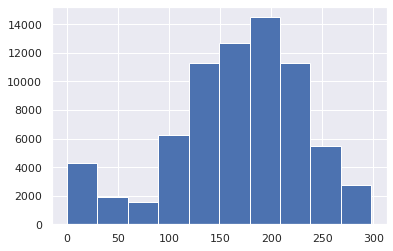

In [22]:
plt.hist(df.time_play[df.time_play < 300])

In [11]:
df.head()

,fielddate,uuid,postroll_req_id,features,is_bayan,music_req_id,time_play,track_id
0,2022-05-25,uu/0038e8fd77270e2a69d4b143bed8b6db,3116d77b-2392-4870-afcf-251d3d6b2a92,"{'artist_like_180d': 0.0, 'artist_like_180d_al...",1,0d44304f-95af-44df-a635-718346927fb4,122,98846547
1,2022-05-25,uu/0038e8fd77270e2a69d4b143bed8b6db,3116d77b-2392-4870-afcf-251d3d6b2a92,"{'artist_like_180d': 0.0, 'artist_like_180d_al...",1,0d44304f-95af-44df-a635-718346927fb4,152,90659859
2,2022-05-25,uu/0038e8fd77270e2a69d4b143bed8b6db,3116d77b-2392-4870-afcf-251d3d6b2a92,"{'artist_like_180d': 0.0, 'artist_like_180d_al...",1,0d44304f-95af-44df-a635-718346927fb4,121,90724794
3,2022-05-25,uu/0038e8fd77270e2a69d4b143bed8b6db,3116d77b-2392-4870-afcf-251d3d6b2a92,"{'artist_like_180d': 0.0, 'artist_like_180d_al...",1,0d44304f-95af-44df-a635-718346927fb4,121,91423945
4,2022-05-25,uu/0038e8fd77270e2a69d4b143bed8b6db,3116d77b-2392-4870-afcf-251d3d6b2a92,"{'artist_like_180d': 0.0, 'artist_like_180d_al...",1,0d44304f-95af-44df-a635-718346927fb4,122,94752656


In [34]:
np.quantile(np.arange(0, 101), 0.9)

90.0

In [168]:
ALL_FEATURES_LIST = [
    'artist_like_180d',
     'artist_like_180d_alice',
     'artist_like_30d',
     'artist_like_30d_alice',
     'artist_play_180d',
     'artist_play_180d_alice',
     'artist_play_30d',
     'artist_play_30d_alice',
     'artist_radio_like_180d',
     'artist_radio_like_180d_alice',
     'artist_radio_like_30d',
     'artist_radio_like_30d_alice',
     'artist_radio_play_180d',
     'artist_radio_play_180d_alice',
     'artist_radio_play_30d',
     'artist_radio_play_30d_alice',
     'artist_radio_skip_180d',
     'artist_radio_skip_180d_alice',
     'artist_radio_skip_30d',
     'artist_radio_skip_30d_alice',
     'artist_skip_180d',
     'artist_skip_180d_alice',
     'artist_skip_30d',
     'artist_skip_30d_alice',
     'time_play',
     'track_like_180d',
     'track_like_180d_alice',
     'track_like_30d',
     'track_like_30d_alice',
     'track_play_180d',
     'track_play_180d_alice',
     'track_play_30d',
     'track_play_30d_alice',
     'track_radio_like_180d',
     'track_radio_like_180d_alice',
     'track_radio_like_30d',
     'track_radio_like_30d_alice',
     'track_radio_play_180d',
     'track_radio_play_180d_alice',
     'track_radio_play_30d',
     'track_radio_play_30d_alice',
     'track_radio_skip_180d',
     'track_radio_skip_180d_alice',
     'track_radio_skip_30d',
     'track_radio_skip_30d_alice',
     'track_skip_180d',
     'track_skip_180d_alice',
     'track_skip_30d',
     'track_skip_30d_alice'
]

ALL_FEATURES = set(ALL_FEATURES_LIST)

NON_USEFUL_FEATURES = {
    'artist_like_180d',
    'artist_like_180d_alice',
    'artist_like_30d',
    'artist_like_30d_alice',
    'artist_radio_like_180d',
     'artist_radio_like_180d_alice',
     'artist_radio_like_30d',
     'artist_radio_like_30d_alice',
    'track_radio_like_180d',
     'track_radio_like_180d_alice',
     'track_radio_like_30d',
     'track_radio_like_30d_alice',
     'track_like_180d_alice',
     'track_like_30d',
     'track_like_30d_alice'
}

def get_req_id_features(features_list, quantile=0.75):
    features_req_id = defaultdict(list)
    
    for item in features_list:
        #if item['time_play'] > 60:
        for feature in ALL_FEATURES - NON_USEFUL_FEATURES:
            features_req_id[feature].append(item.get(feature, 0))
    
    features_aggregated = {feature + f'_{int(quantile*100)}_quantile': np.quantile(features_req_id[feature], quantile) for feature in features_req_id}
    
    return features_aggregated

In [176]:
track_lengths = df.groupby(by='postroll_req_id').agg(
    len_session=pd.NamedAgg(column="track_id", aggfunc="count"),
    is_bayan=pd.NamedAgg(column="is_bayan", aggfunc="first"),
    uuid=pd.NamedAgg(column="uuid", aggfunc="first"),
).reset_index(drop=True)

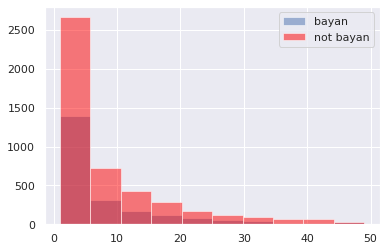

In [234]:
thr = 50
plt.hist(track_lengths.len_session[np.logical_and(track_lengths.len_session < thr, track_lengths.is_bayan)], alpha=0.5, label='bayan')
plt.hist(track_lengths.len_session[np.logical_and(track_lengths.len_session < thr, track_lengths.is_bayan == 0)], alpha=0.5, color='red', label='not bayan')
plt.legend()
plt.show()

(array([1299.,  588.,  330.,  233.,    0.,  213.,  173.,  173.,  154.,
         120.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

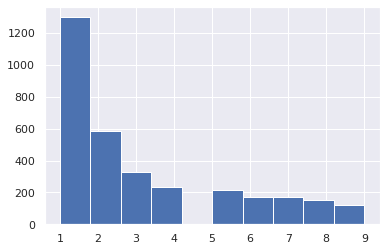

In [181]:
np.quantile([5], 0.75)

5.0

In [169]:
np.sum(grouped_df.is_bayan), len(grouped_df.is_bayan)

(1798, 5972)

track_radio_play_180d 20183


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

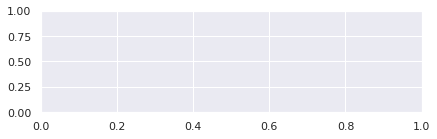

In [149]:
i = 1
plt.figure(figsize=(15, 40))
for feature in ALL_FEATURES - NON_USEFUL_FEATURES:
    print(feature, len(set([item.get(feature, 0) for item in df.features])))
    thr = np.max([item.get(feature, 0) for item in df.features])/2
    plt.subplot(len(ALL_FEATURES - NON_USEFUL_FEATURES)//2 + 1, 2, i)
    hist_data = np.array([item.get(feature, 0) for item in df[df.is_bayan == 0].features])
    #plt.hist(hist_data[hist_data < thr], alpha=0.5, color='blue', label='is not bayan', density=True)
    hist_data.plot.kde(label='not bayan')
    hist_data = np.array([item.get(feature, 0) for item in df[df.is_bayan == 1].features])
    hist_data.plot.kde(label='bayan')

    #plt.hist(hist_data[hist_data < thr], alpha=0.5, color='red', label='is bayan', density=True)
    plt.xlim(0, thr)
    plt.title(f'{feature}')
    plt.legend()
    i += 1
plt.show()

In [199]:
grouped_df = df.groupby(by='postroll_req_id').agg(
    is_bayan=pd.NamedAgg(column="is_bayan", aggfunc="first"),
    uuid=pd.NamedAgg(column="uuid", aggfunc="first"),
    features_agg=pd.NamedAgg(column="features", aggfunc=get_req_id_features)
).reset_index(drop=True)
grouped_df = grouped_df[grouped_df.features_agg != {}].reset_index(drop=True)
for feature in grouped_df.features_agg[0]:
    if '180' in feature:
        grouped_df[feature] = [item[feature] for item in grouped_df.features_agg]
grouped_df = grouped_df.drop(columns=['features_agg'])

In [203]:
len(grouped_df), sum(grouped_df.is_bayan)/len(grouped_df)

(7121, 0.32256705518887796)

In [204]:
train_uuid, test_uuid = train_test_split(list(set(grouped_df.uuid)), test_size=0.2, random_state=42)

In [205]:
grouped_df.head()

,is_bayan,uuid,track_radio_play_180d_75_quantile,artist_play_180d_alice_75_quantile,artist_skip_180d_75_quantile,track_play_180d_75_quantile,artist_play_180d_75_quantile,track_like_180d_75_quantile,track_radio_skip_180d_alice_75_quantile,artist_radio_skip_180d_75_quantile,artist_skip_180d_alice_75_quantile,track_play_180d_alice_75_quantile,artist_radio_skip_180d_alice_75_quantile,artist_radio_play_180d_75_quantile,track_skip_180d_alice_75_quantile,artist_radio_play_180d_alice_75_quantile,track_skip_180d_75_quantile,track_radio_skip_180d_75_quantile,track_radio_play_180d_alice_75_quantile
0,0,uu/147d44188a62cde8486ea27a61217444,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0,uu/06aa26a6efa449b052ba23a52f12077b,1.441507,0.498078,0.286071,0.0,1.834827,0.0,0.0,0.0,0.0,0.0,0.0,4.420222,0.0,0.496164,0.0,0.0,0.0
2,1,uu/2d3cb9136540adadc21832d627baa78d,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0,uu/2169bdaf974654d20fe53fd36d5498c2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,1,uu/6108ce1268237621c559a14fa527861b,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [231]:
sum(y_train.is_bayan)/len(y_train)

0.3252018252018252

In [233]:
sum(y_test.is_bayan)

444

In [232]:
sum(y_test.is_bayan)/len(y_test)

0.3120168657765285

In [206]:
X = grouped_df.drop(columns=['is_bayan', 'uuid'])
y = grouped_df[['is_bayan']]
X_train = X[[uuid in train_uuid for uuid in grouped_df.uuid]]
X_test = X[[uuid in test_uuid for uuid in grouped_df.uuid]]
y_train = y[[uuid in train_uuid for uuid in grouped_df.uuid]]
y_test = y[[uuid in test_uuid for uuid in grouped_df.uuid]]

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

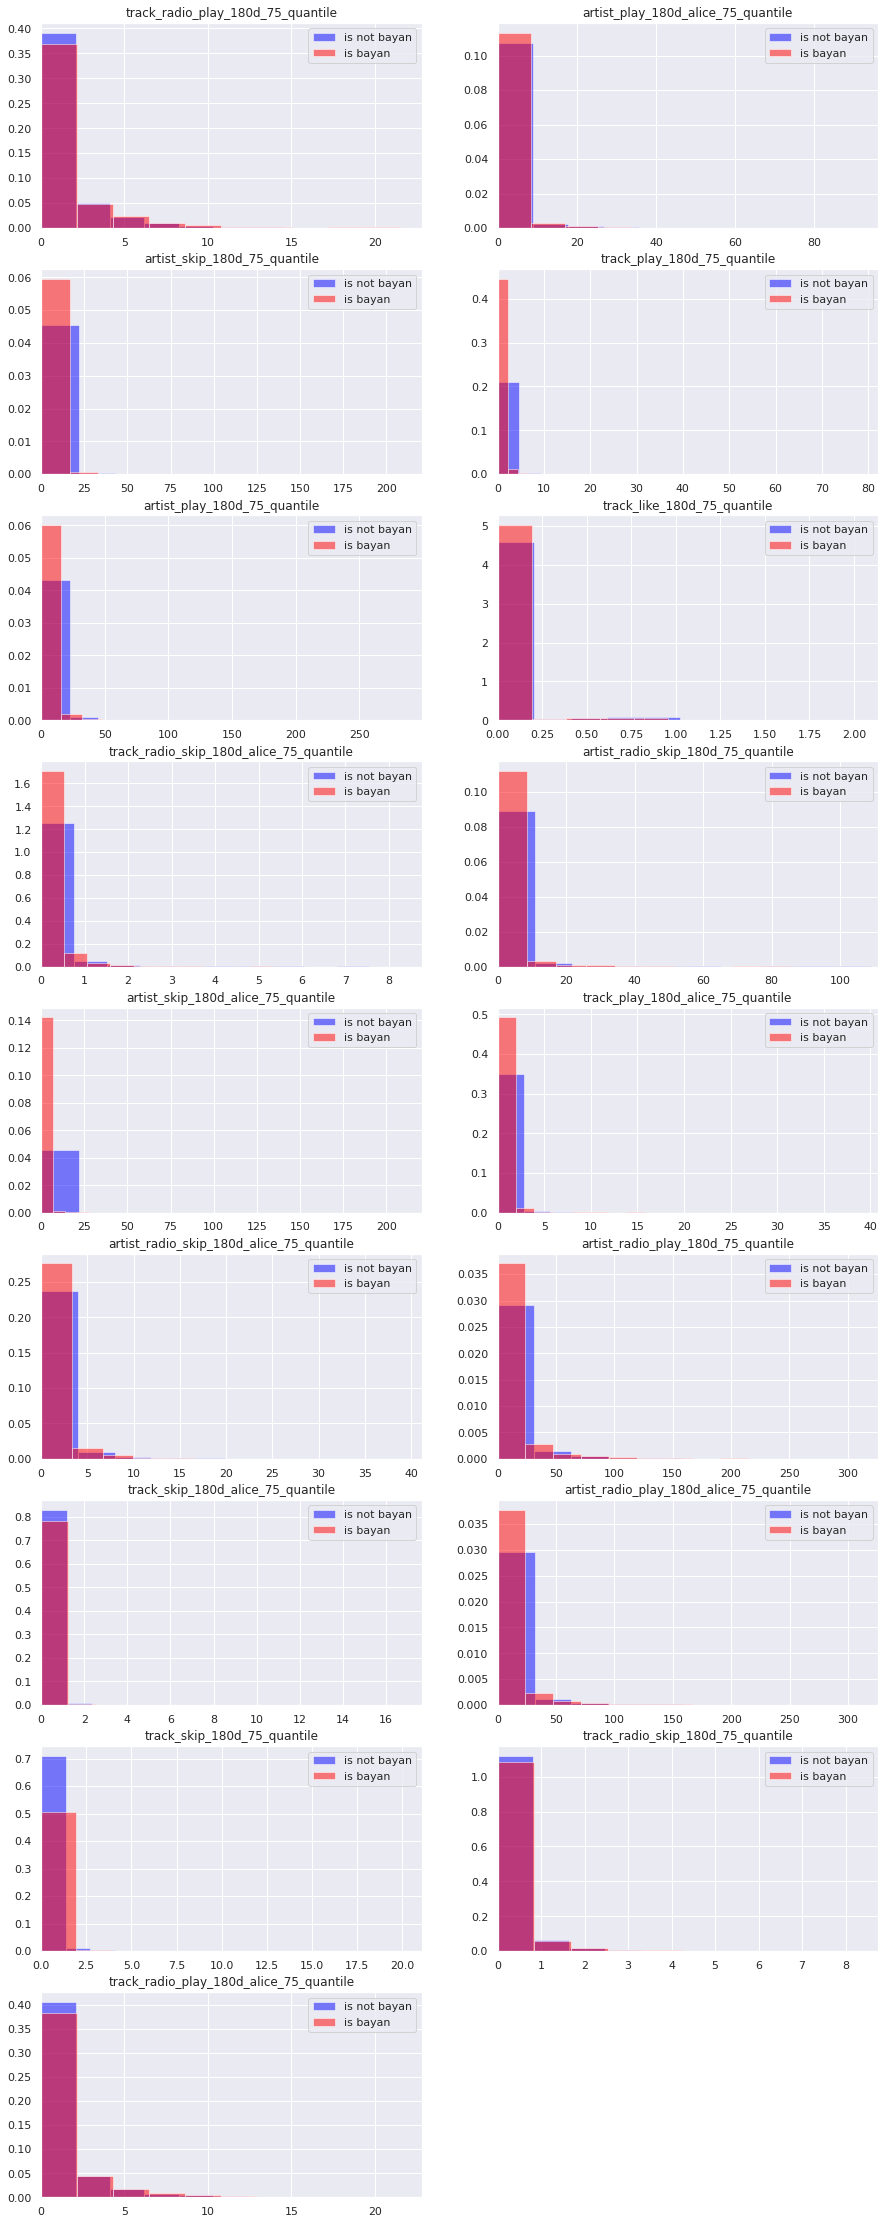

In [212]:
i = 1
plt.figure(figsize=(15, 40))
for feature in list(X):
    thr = np.max(X[feature])/2
    plt.subplot(len(list(X))//2 + 1, 2, i)
    hist_data = pd.Series(X[feature][grouped_df.is_bayan == 0])
    plt.hist(hist_data[hist_data < thr], alpha=0.5, color='blue', label='is not bayan', density=True)
    
    hist_data = pd.Series(X[feature][grouped_df.is_bayan == 1])
    plt.hist(hist_data[hist_data < thr], alpha=0.5, color='red', label='is bayan', density=True)
    plt.xlim(0, thr)
    plt.title(f'{feature}')
    plt.legend()
    i += 1
plt.show()

In [216]:
clf = CatBoostClassifier(iterations=100,
                           depth=4,
                           learning_rate=0.1,
                           verbose=False)
clf = RandomForestClassifier()

In [221]:
clf.fit(X_train, y_train.is_bayan)

RandomForestClassifier()

In [222]:
print(np.sum(clf.predict(X_test)), np.sum(y_test))

96 is_bayan    444
dtype: int64


In [226]:
np.sum(clf.predict(X_test)*y_test.is_bayan)

32

In [190]:
y_train

,is_bayan
0,0
1,0
2,1
3,0
4,1
...,...
5966,1
5967,0
5968,0
5970,0


In [249]:
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
import scipy.stats as sps
from sklearn.metrics import precision_score, recall_score
sns.set()

df = pd.read_csv('puid_bayan_with_features.csv')
df['is_bayan'] = np.logical_or(df.artist_bayan > 2, df.track_bayan > 2)
print(f'Num bayans: {np.sum(df.is_bayan)}, share bayans: {np.sum(df.is_bayan)/len(df.is_bayan)}')
df['artist_and_track_180d'] = df.artist_plays_180d + df.track_plays_180d
df['artist_and_track_30d'] = df.artist_plays_30d + df.track_plays_30d
df['artist_and_track_skips_180d'] = df.artist_skips_180d + df.track_skips_180d
df['artist_and_track_skips_30d'] = df.artist_skips_30d + df.track_skips_30d
target_bayan_artist = df.artist_bayan > 1
target_bayan_track = df.track_bayan > 1
X = df.drop(['puid', 'title', 'artist_name', 'id', 'track_id', 'timestamp', 'artist_bayan', 'track_bayan', 'is_bayan'], axis=1)

Num bayans: 54, share bayans: 0.3624161073825503


In [276]:
list(X), len(list(X))

(['album_plays_180d',
  'album_plays_30d',
  'album_plays_rec_180d',
  'artist_plays_180d',
  'artist_plays_30d',
  'artist_plays_rec_180d',
  'artist_skips_180d',
  'artist_skips_30d',
  'track_long_history_plays_30d',
  'track_plays_180d',
  'track_plays_30d',
  'track_plays_rec_180d',
  'track_skips_180d',
  'track_skips_30d',
  'artist_and_track_180d',
  'artist_and_track_30d',
  'artist_and_track_skips_180d',
  'artist_and_track_skips_30d'],
 18)

In [266]:
useful_features = list(X)

def precision_recall_data_with_thr(df):
    for_plotly = {'precision': [], 'recall': [], 'feature': [], 'thr': []}
    for feature in useful_features:
        for thr in np.linspace(np.min(df[feature]), min(100, np.max(df[feature])), 200):
            predictions = df[feature] >= thr
            precision_score_calc = precision_score(df.is_bayan, predictions)
            recall_score_calc = recall_score(df.is_bayan, predictions)
            if 0.6 < precision_score_calc and  0.1 < recall_score_calc < 1:
                for_plotly['precision'].append(precision_score_calc)
                for_plotly['recall'].append(recall_score_calc)
                for_plotly['feature'].append(feature)
                for_plotly['thr'].append(thr)
    df_for_plotly = pd.DataFrame(for_plotly)
    return df_for_plotly


In [275]:
feature = "artist_and_track_skips_180d"
thr = 14
bayan_pred = df[feature] > thr
print(f'{feature} > {thr}: precision = {precision_score(df.is_bayan, bayan_pred)}, recall = {recall_score(df.is_bayan, bayan_pred)}')

artist_and_track_skips_180d > 14: precision = 0.6896551724137931, recall = 0.37037037037037035


In [268]:
df_for_plotly = precision_recall_data_with_thr(df)
px.scatter(df_for_plotly, x='recall', y='precision', color='feature', hover_name='thr')


singular matrix


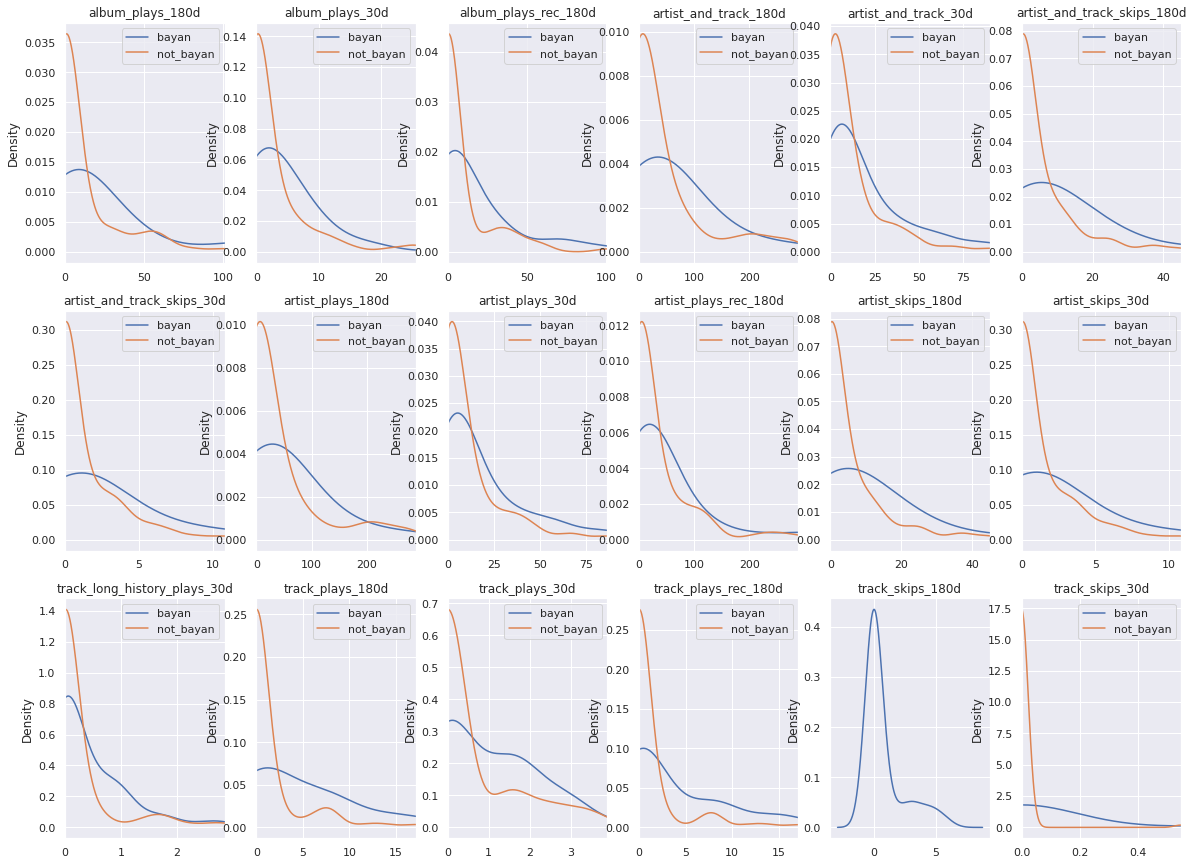

In [277]:
plt.figure(figsize=(20,15))
# is_bayan = np.logical_or(target_bayan_artist, target_bayan_track)
index = 1
for feature in sorted(list(X)):
    is_bayan = df.is_bayan
    bayan_data = df[feature][is_bayan]
    non_bayan_data = df[feature][np.logical_not(is_bayan)]
    plt.subplot(3, 6, index)
    try:
        pd.Series(bayan_data).plot.kde(label='bayan')
        pd.Series(non_bayan_data).plot.kde(label='not_bayan')
        plt.xlim(0, min(np.max(non_bayan_data), np.max(bayan_data)))
        plt.legend()
    except Exception as e:
        print(e)
        pass
    plt.title(feature)
    index += 1
plt.show()

In [74]:
feature = 'artist_plays_30d'

bayan_data = df[feature][np.logical_or(target_bayan_artist, target_bayan_track)]
non_bayan_data = df[feature][np.logical_not(np.logical_or(target_bayan_artist, target_bayan_track))]
fig = ff.create_distplot([bayan_data, non_bayan_data], ['bayan', 'non_bayan'], bin_size=1, show_hist=False,
                         show_rug=False)
fig.show()


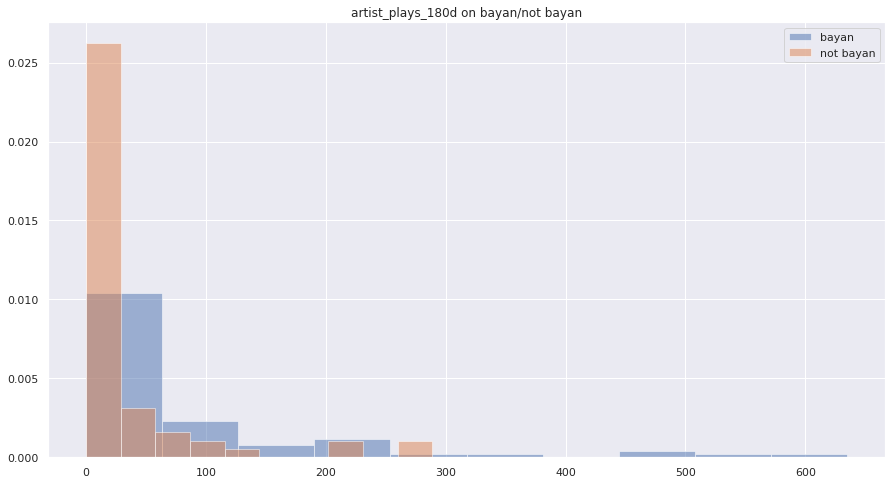

In [42]:
plt.figure(figsize=(15,8))
plt.hist(df[feature][np.logical_or(target_bayan_artist, target_bayan_track)], label='bayan', density=True, alpha=0.5)
plt.hist(df[feature][np.logical_not(np.logical_or(target_bayan_artist, target_bayan_track))], label='not bayan', density=True, alpha=0.5)
plt.title(f'{feature} on bayan/not bayan')
plt.legend()
plt.show()

[Text(470.8125, 391.392, 'X[9] <= 2.902\ngini = 0.486\nsamples = 149\nvalue = [87, 62]'),
 Text(261.5625, 304.416, 'X[4] <= 50.79\ngini = 0.356\nsamples = 108\nvalue = [83, 25]'),
 Text(209.25, 217.44, 'X[4] <= 3.008\ngini = 0.322\nsamples = 104\nvalue = [83, 21]'),
 Text(104.625, 130.464, 'X[3] <= 3.596\ngini = 0.436\nsamples = 53\nvalue = [36, 17]'),
 Text(52.3125, 43.488, 'gini = 0.403\nsamples = 50\nvalue = [36, 14]'),
 Text(156.9375, 43.488, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(313.875, 130.464, 'X[1] <= 7.071\ngini = 0.145\nsamples = 51\nvalue = [47, 4]'),
 Text(261.5625, 43.488, 'gini = 0.0\nsamples = 39\nvalue = [39, 0]'),
 Text(366.1875, 43.488, 'gini = 0.444\nsamples = 12\nvalue = [8, 4]'),
 Text(313.875, 217.44, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(680.0625, 304.416, 'X[8] <= 2.87\ngini = 0.176\nsamples = 41\nvalue = [4, 37]'),
 Text(627.75, 217.44, 'X[10] <= 3.289\ngini = 0.139\nsamples = 40\nvalue = [3, 37]'),
 Text(523.125, 130.464, 'X[7] <= 4.71

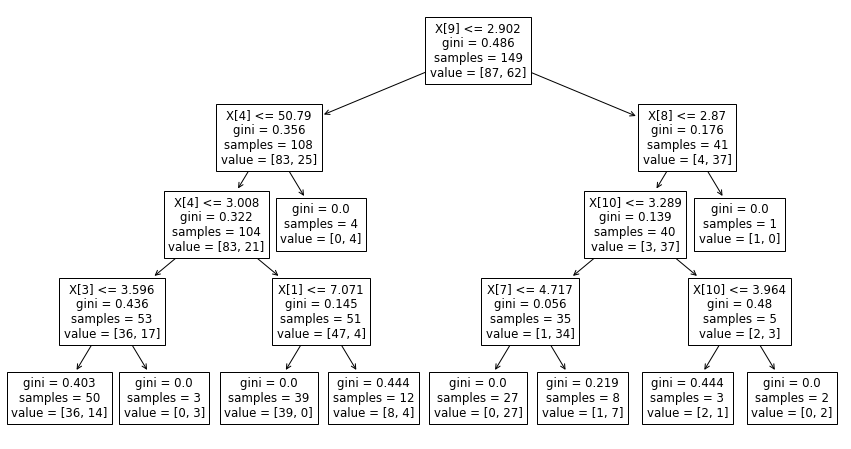

In [27]:
clf = DecisionTreeClassifier(max_depth=4).fit(df, target_bayan_track)
plt.figure(figsize=(15, 8))
plot_tree(clf)